In [1]:
import matplotlib.pyplot as plt
from planners.lazy_prm import LazyPRM
from utils.lazy_prm_visualize import lazy_prm_visualize
from utils.collision_checker import CollisionChecker
from environment import get_all_scenes

In [2]:
# ---- Konfiguration für LazyPRM ----
config = {
    "initialRoadmapSize": 150,
    "updateRoadmapSize": 50,
    "kNearest": 10,
    "maxIterations": 25
}

# ---- Szenen laden ----
scenes = get_all_scenes()


🔍 Szene: U-Shape
✅ Pfad gefunden in Szene: U-Shape, Länge: 11


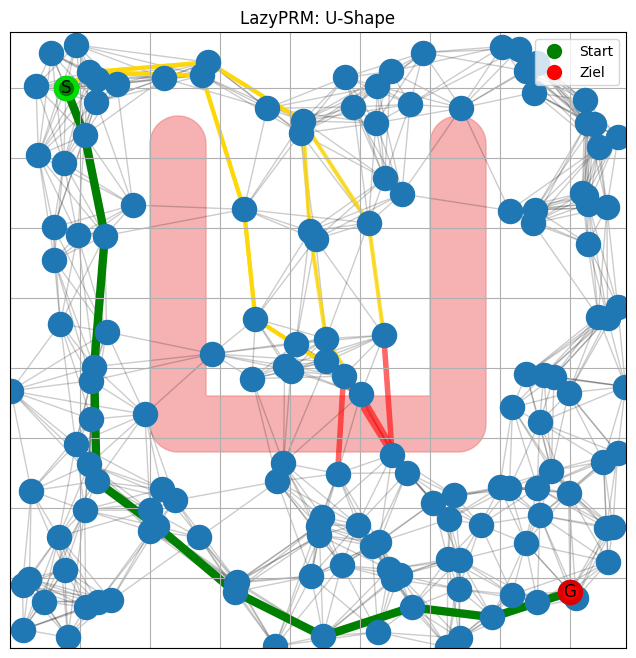


🔍 Szene: L-Shape
❌ Kein Pfad gefunden in Szene: L-Shape


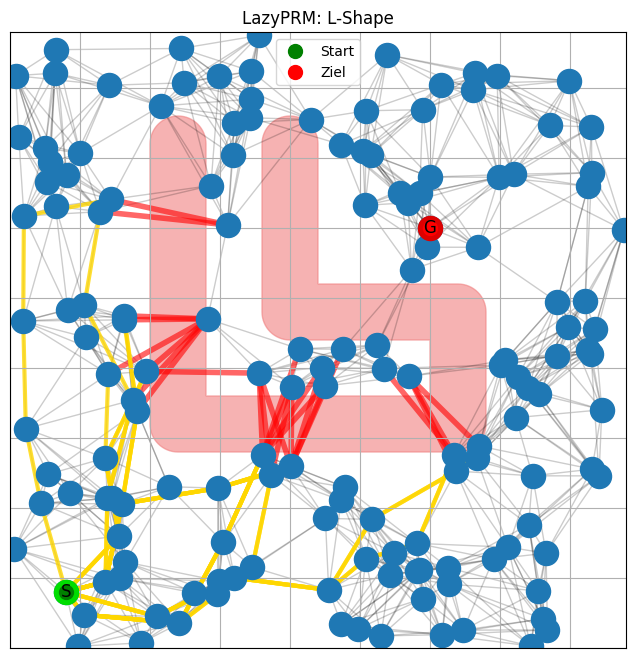


🔍 Szene: Cross-Shape
❌ Kein Pfad gefunden in Szene: Cross-Shape


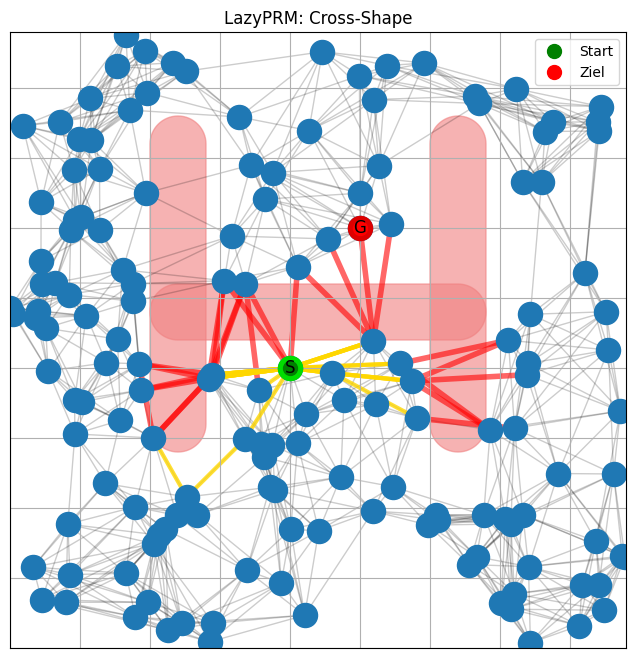


🔍 Szene: Corridor
❌ Kein Pfad gefunden in Szene: Corridor


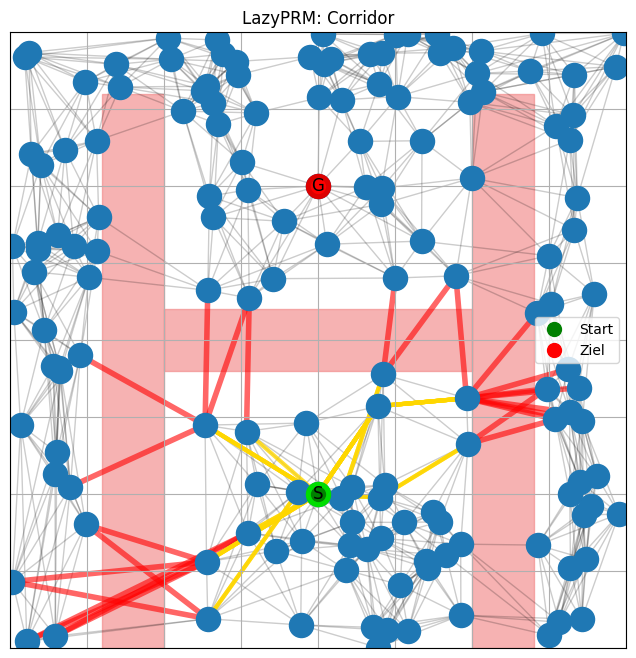


🔍 Szene: Complex Shape
❌ Kein Pfad gefunden in Szene: Complex Shape


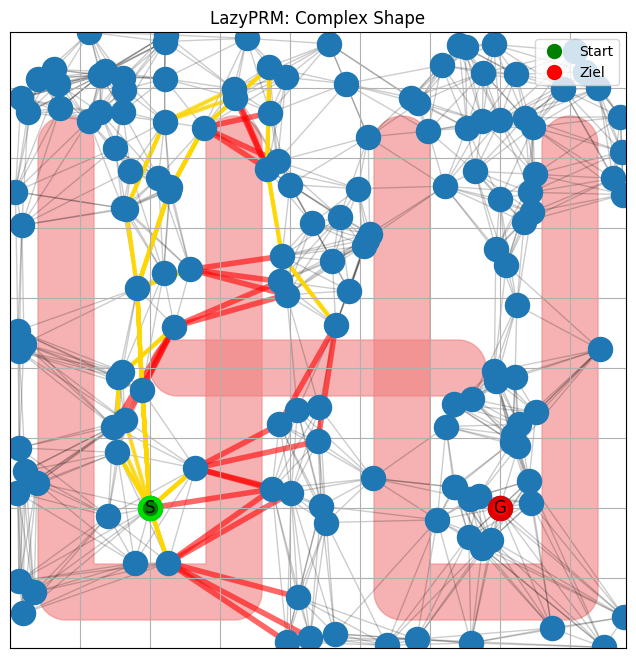


🔍 Szene: Multiple Obstacles
✅ Pfad gefunden in Szene: Multiple Obstacles, Länge: 7


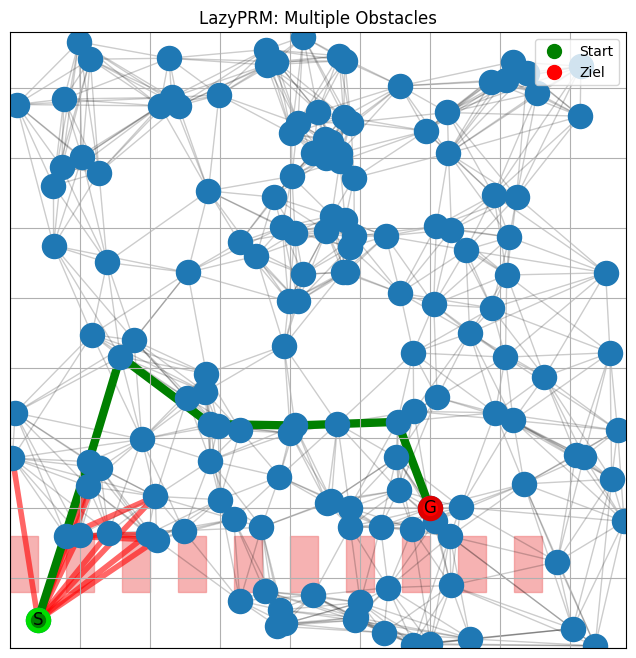


🔍 Szene: Random Obstacles
✅ Pfad gefunden in Szene: Random Obstacles, Länge: 11


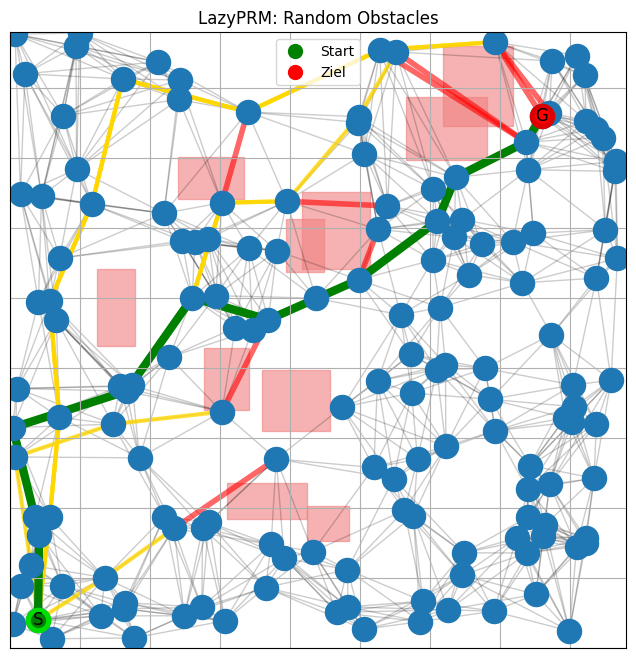

In [3]:
# ---- Jede Szene durchplanen ----
for scene_name, (scene, limits, (start_pos, goal_pos)) in scenes:
    print(f"\n🔍 Szene: {scene_name}")
    start = [list(start_pos)]
    goal = [list(goal_pos)]

    # CollisionChecker instanziieren
    collision_checker = CollisionChecker(scene, limits)

    # LazyPRM-Planer erstellen
    planner = LazyPRM(collision_checker, limits)

    # Planung starten
    path = planner.plan_path(start, goal, config)

    if not path:
        print(f"❌ Kein Pfad gefunden in Szene: {scene_name}")
    else:
        print(f"✅ Pfad gefunden in Szene: {scene_name}, Länge: {len(path)}")

    # Visualisierung
    fig, ax = plt.subplots(figsize=(8, 8))
    lazy_prm_visualize(planner, solution=path, ax=ax)
    ax.set_title(f"LazyPRM: {scene_name}")
    ax.plot(start[0][0], start[0][1], "go", markersize=10, label="Start")
    ax.plot(goal[0][0], goal[0][1], "ro", markersize=10, label="Ziel")
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    ax.grid(True)
    ax.legend()
    plt.show()

In [4]:
from scipy.spatial.distance import euclidean

if path:
    coords = planner.get_path_coordinates(path)
    length = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:]))
    print(f"Pfadlänge: {length:.2f}")
else:
    print("Keine Pfadlänge berechenbar.")


Pfadlänge: 30.79
